[View in Colaboratory](https://colab.research.google.com/github/thiwankajayasiri/BioSPPy/blob/master/Lab6DATA472.ipynb)

In [0]:
import tensorflow as tf

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# 2. Download data set
# file_ds = drive.CreateFile({'id': '1_5z8l0J9tBt9WuwwY1wTq7WpmvYfwGCB'})
# file_ds.GetContentFile('dataset.zip')
file_ds2 = drive.CreateFile({'id': '1FIZsUj4I2Hb-HtKPGaANQ-KhiIihodMD'})
file_ds2.GetContentFile('dataset2.zip')
  
# !rm -rf dataset-master
!rm -rf dataset2-master  

# !unzip -q dataset.zip
!unzip -q dataset2.zip

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


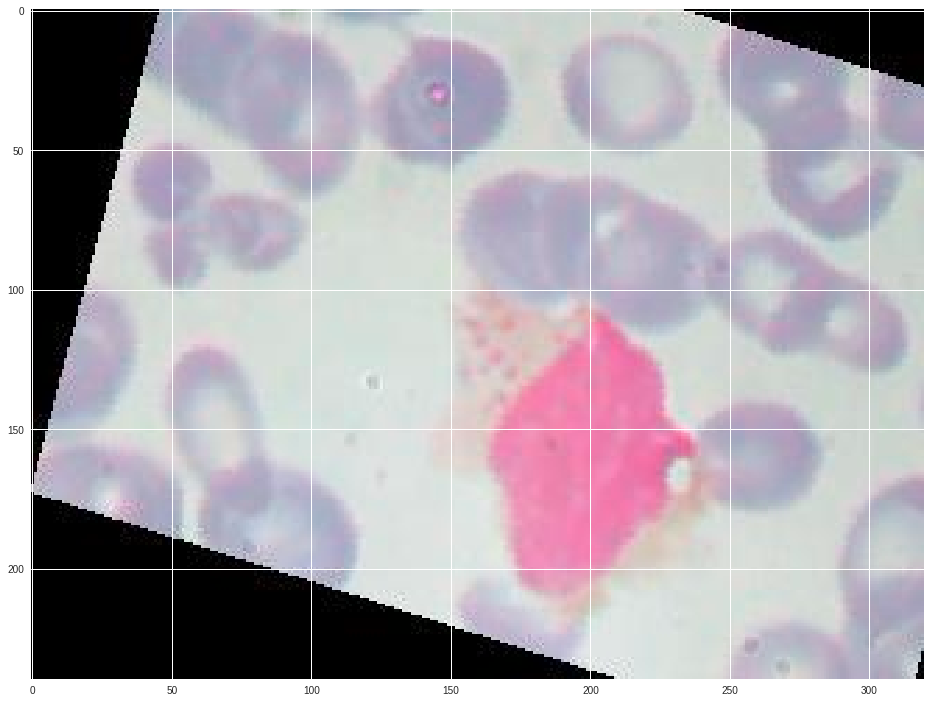

In [26]:
image = cv2.imread("dataset2-master/images/TRAIN/MONOCYTE/_0_5226.jpeg")
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

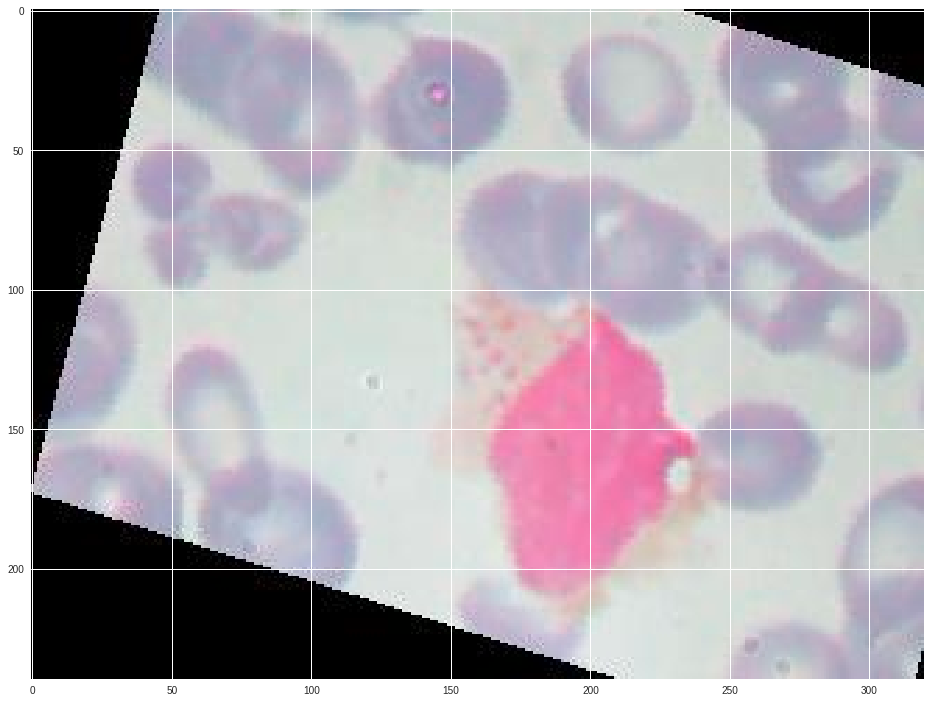

In [32]:
image = cv2.imread("dataset2-master/images/TRAIN/MONOCYTE/_0_5226.jpeg")
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()


In [27]:
labels = ["NEUTROPHIL",  
          "EOSINOPHIL",     
          "MONOCYTE",       
          "LYMPHOCYTE"]
img_rows,img_cols=60,80
input_shape = (img_rows, img_cols, 3)

!pip install tqdm
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
            elif wbc_type in ['MONOCYTE']:
                label = 3  
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
            else:
                label = 5
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=input_shape)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data('dataset2-master/images/TRAIN/')
X_test, y_test = get_data('dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)

# normalize to 0 to 1
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

    100% |████████████████████████████████| 51kB 2.1MB/s 


  0%|          | 0/2478 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
100%|██████████| 624/624 [00:01<00:00, 528.05it/s]


# Step 1 Answers

In your notebook answer the following prompts:

**What is an epoch?**

*Epoch is an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation.Hence  a number of epochs means how many times you go through your training set.*


**What layers are there in the given model?**

Convolutional Layer, Pooling Layer, and Fully-Connected Layer

*on the given picture there has to be an INPUT , CONV , RELU , POOL and FC*.


*INPUT  we hold 16 X16  will hold the raw pixel values of the image*

*CONV layer  - will compute the output of the neurons that are connected to local regions in the input . Each computing a dot product between their weights and small region they are connected to in the input volume.*

*RELU (Rectified Linear Units)layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged.
*POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as {16X16X2}

*FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size {1X1X10}, where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.*.

*On the other hand, the RELU/POOL layers will implement a fixed function. The parameters in the CONV/FC layers will be trained with gradient descent so that the class scores that the ConvNet computes are consistent with the labels in the training set for each image*

**In summary:**

*A ConvNet architecture is in the simplest case a list of Layers that transform the image volume into an output volume (e.g. holding the class scores)
There are a few distinct types of Layers (e.g. CONV/FC/RELU/POOL are by far the most popular)
Each Layer accepts an input 3D volume and transforms it to an output 3D volume through a differentiable function
Each Layer may or may not have parameters (e.g. CONV/FC do, RELU/POOL don’t)
Each Layer may or may not have additional hyperparameters (e.g. CONV/FC/POOL do, RELU doesn’t)*

**Why is the overall accuracy only about 25%? What does this imply about the learning in our model?**

*This behavior is closely related to the bias-variance trade-off. If the train long enough, we'll have a very high train accuracy (25% low) and the validation accuracy will decrease because  the model won't be able to generalize well. If we train well enough the data will overfit and low enough data will underfit.* 




# Build CNN model

In [0]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.Sequential()


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Step 2

Add convolution layers. Review the class example and experiment on your own. Since this is often a lot of guess work based on heuristics, try:
adding 2 convolution 2D layers with size 3 kernels and Relu activation. 

One with 32 and one with 64 filters.
Add a maxpool layer of size 2
Add a dropout layer with 0.25


In [0]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

model = tf.keras.models.Sequential()

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [0]:
batch_size = 128
num_classes = 10
epochs = 12

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import losses

In [60]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
x_train, y_train = get_data('dataset2-master/images/TRAIN/')
x_test, y_test = get_data('dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 10)
y_testHot = to_categorical(y_test, num_classes = 10)

# normalize to 0 to 1
X_train=np.array(x_train)
X_train=x_train/255.0

X_test=np.array(x_test)
X_test=x_test/255.0

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))


  0%|          | 0/2478 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
100%|██████████| 624/624 [00:01<00:00, 540.78it/s]


x_train shape: (9957, 60, 80, 3)
9957 train samples
2487 test samples


# Simple complie and fit - Step 3

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_trainHot, epochs=5)

Epoch 1/5
9957/9957 [==============================] - 6s 561us/step - loss: 2.0279 - acc: 0.2434
Epoch 2/5
9957/9957 [==============================] - 4s 433us/step - loss: 1.5128 - acc: 0.2493
Epoch 3/5
9957/9957 [==============================] - 4s 421us/step - loss: 1.4796 - acc: 0.2454
Epoch 4/5
9957/9957 [==============================] - 4s 386us/step - loss: 1.4569 - acc: 0.2513
Epoch 5/5
9957/9957 [==============================] - 3s 344us/step - loss: 1.4420 - acc: 0.2447


In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 58, 78, 32)        896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 76, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 38, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 28, 38, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 68096)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8716416   
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
__________

In [61]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_trainHot, epochs=10)

Epoch 1/10
9957/9957 [==============================] - 19s 2ms/step - loss: 1.4768 - acc: 0.3392
Epoch 2/10
9957/9957 [==============================] - 14s 1ms/step - loss: 1.0604 - acc: 0.5192
Epoch 3/10
9957/9957 [==============================] - 14s 1ms/step - loss: 0.8818 - acc: 0.6037
Epoch 4/10
9957/9957 [==============================] - 14s 1ms/step - loss: 0.8955 - acc: 0.6013
Epoch 5/10
9957/9957 [==============================] - 14s 1ms/step - loss: 0.7450 - acc: 0.6666
Epoch 6/10
9957/9957 [==============================] - 14s 1ms/step - loss: 0.6617 - acc: 0.6990
Epoch 7/10
9957/9957 [==============================] - 14s 1ms/step - loss: 0.6343 - acc: 0.7250
Epoch 8/10
9957/9957 [==============================] - 14s 1ms/step - loss: 0.5757 - acc: 0.7477
Epoch 9/10
9957/9957 [==============================] - 14s 1ms/step - loss: 0.5285 - acc: 0.7797
Epoch 10/10
9957/9957 [==============================] - 14s 1ms/step - loss: 0.4612 - acc: 0.8037


In [65]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_trainHot, epochs=30)

Epoch 1/30
9957/9957 [==============================] - 15s 2ms/step - loss: 0.4199 - acc: 0.8203
Epoch 2/30
9957/9957 [==============================] - 14s 1ms/step - loss: 0.3706 - acc: 0.8459
Epoch 3/30
9957/9957 [==============================] - 14s 1ms/step - loss: 0.3703 - acc: 0.8521
Epoch 4/30
9957/9957 [==============================] - 14s 1ms/step - loss: 0.3023 - acc: 0.8765
Epoch 5/30
9957/9957 [==============================] - 14s 1ms/step - loss: 0.2610 - acc: 0.9008
Epoch 6/30
9957/9957 [==============================] - 14s 1ms/step - loss: 0.2451 - acc: 0.9049
Epoch 7/30
9957/9957 [==============================] - 14s 1ms/step - loss: 0.2102 - acc: 0.9194
Epoch 8/30
9957/9957 [==============================] - 14s 1ms/step - loss: 0.2008 - acc: 0.9218
Epoch 9/30
9957/9957 [==============================] - 14s 1ms/step - loss: 0.1657 - acc: 0.9391
Epoch 10/30
9957/9957 [==============================] - 14s 1ms/step - loss: 0.1559 - acc: 0.9437
Epoch 11/30
9957/99

# Test prediction - Step 3.1

             precision    recall  f1-score   support

 NEUTROPHIL       0.62      0.78      0.69       624
 EOSINOPHIL       0.77      0.66      0.71       623
   MONOCYTE       0.95      0.75      0.84       620
 LYMPHOCYTE       0.91      0.99      0.95       620

avg / total       0.81      0.79      0.80      2487



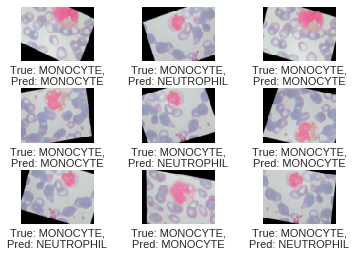

In [66]:
preds = model.predict(X_test)

cls_pred = np.argmax(preds, axis=1)
print(sklearn.metrics.classification_report(y_test, cls_pred, target_names=labels))

img_shape = input_shape

#show the images
import matplotlib.pyplot as plt

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(labels[cls_true[i]-1])
        else:
            xlabel = "True: {0},\nPred: {1}".format(labels[cls_true[i]-1],
                                                    labels[cls_pred[i]-1])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
plot_images(X_test[0:9], np.argmax(y_testHot[0:9], axis=1), cls_pred[0:9])

             precision    recall  f1-score   support

 NEUTROPHIL       0.62      0.78      0.69       624
 EOSINOPHIL       0.77      0.66      0.71       623
   MONOCYTE       0.95      0.75      0.84       620
 LYMPHOCYTE       0.91      0.99      0.95       620

avg / total       0.81      0.79      0.80      2487



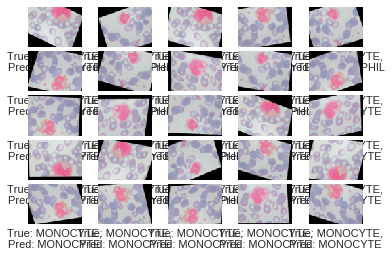

In [68]:
preds = model.predict(X_test)

cls_pred = np.argmax(preds, axis=1)
print(sklearn.metrics.classification_report(y_test, cls_pred, target_names=labels))

img_shape = input_shape

#show the images
import matplotlib.pyplot as plt

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 25
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(5, 5)
    fig.subplots_adjust(hspace=0.1, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(labels[cls_true[i]-1])
        else:
            xlabel = "True: {0},\nPred: {1}".format(labels[cls_true[i]-1],
                                                    labels[cls_pred[i]-1])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
plot_images(X_test[0:25], np.argmax(y_testHot[0:25], axis=1), cls_pred[0:25])